# Image Caption Generator

This notebook is a to-do guide about generating captions for images and it's comparision to the latest models for generating these captions. 

# Problem Description

Image caption generation models are models that analyze images and automatically generate relevant captions. 

They combine techniques from computer vision and natural language processing to “understand” an image's visual content and express it in natural language. This task is complex because it requires not only recognizing objects in an image but also understanding their context, relationships, and the ability to translate this understanding into a coherent sentence.

## Intuition

- Images can be compressed to vectors of a multitude of features. These can be generated using a CNN (Convolutional Neural Network).

- Our goal is to generate a suitable `caption` for the image given, which is a sequence of texts. We can generate a sequence using an RNN (Recurrent Neural Network) like LSTM(Long-Short Term Memory) or GRU (Gated Recurrent Unit)

- We push the Image vector(feature vector) as our initial state for RNN and try to generate text at each time-step of the RNN using the feature vector.

- While training, we will already have our images and captions at the ready. Get our feature vector of the image and push the feature vector against a untrained/ pre-trained RNN and compare it with our actual caption output. Train it with back-prop to get better at accuracy. 

# Strategy

- Use the pretrained `Inception_V3` model to generate the feature vector of the image.

- Pass it through an RNN to generate an output embedding and compare it to the actual output in the embedding form, use an error function with these two and backprop to get a fix of this hybrid model, to generate accurate captions. 

- We are going to implement both `LSTM` and `GRU` architectures as our caption generation models.

- We are using the `MSCOCO` Dataset for our task of image caption generation, with an 80-20 train-test split.

### Models

#### LSTM

#### GRU

#### InceptionV3

### Model Scoring Approach

#### BLEU Score

BLEU (Bilingual Evaluation Understudy) is a widely used metric for evaluating the quality of machine-translated text.

BLEU is an algorithm that measures the correspondence between a machine translation and professional human translations of the same text.

> Reference: https://en.wikipedia.org/wiki/BLEU

BLEU compares n-grams (sequences of n consecutive words) of the machine-translated text with n-grams of reference human translations. The algorithm:

- Calculates n-gram precision scores (typically for 1 to 4-grams)
- Applies a brevity penalty to penalize short translations
- Combines these scores using a weighted geometric mean

- BLEU scores range from 0 to 1, where 1 indicates a perfect match with the reference translation.
- In practice, scores between 0.6-0.7 are considered very good.
- Scores closer to 1 are rare and may indicate overfitting

> Reference: https://towardsdatascience.com/foundations-of-nlp-explained-bleu-score-and-wer-metrics-1a5ba06d812b

In [203]:
from nltk.translate.bleu_score import sentence_bleu

reference = [["this", "is", "a", "test"]]
candidate = ["this", "is", "test"]

score = sentence_bleu(reference, candidate)
print(score)

8.987727354491445e-155


/Users/smatcha/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/smatcha/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


# Code

## Installs and Environment Setup

In [ ]:
%pip install numpy tensorflow
%pip install keras # For latest versions of tensorflow, it is advised to use keras externally 
%pip install keras_nlp

## Imports

In [2]:
import importlib, importlib_metadata

In [3]:
def print_module_version(module_name):
    try:
        version = importlib.metadata.version(module_name)
        print(f"{module_name} Version: ",version)
    except importlib.metadata.PackageNotFoundError:
         print(f"{module_name} is not installed or version information is not available")

In [148]:
import numpy as np
print_module_version("numpy")
import pandas as pd
print_module_version("pandas")
import tensorflow as tf
print_module_version("tensorflow")
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Add
from keras_nlp.tokenizers import Tokenizer, WordPieceTokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical 
print_module_version("keras")
# Importing Pycoctools for potential dataset handling from the coco["train2017"] API -- Python Version
import pycocotools
print_module_version("pycocotools")
from sklearn.model_selection import train_test_split
print_module_version("sklearn")
from nltk.translate.bleu_score import sentence_bleu
print_module_version("nltk")
from scipy.spatial.distance import cosine
print_module_version("scipy")
import re
print_module_version("re")
import pickle
print_module_version("pickle")
import os
print_module_version("os")
import glob
print_module_version("glob")
from PIL import Image
print_module_version("PIL")
from tqdm import tqdm
print_module_version("tqdm")

numpy Version:  1.26.4
pandas Version:  2.0.3
tensorflow Version:  2.17.0
keras Version:  3.6.0
pycocotools Version:  2.0
sklearn is not installed or version information is not available
nltk Version:  3.8.1
scipy Version:  1.11.1
re is not installed or version information is not available
pickle is not installed or version information is not available
os is not installed or version information is not available
glob is not installed or version information is not available
PIL is not installed or version information is not available
tqdm Version:  4.65.0


In [5]:
%matplotlib inline
from pycocotools.coco import COCO
import skimage.io as io
print_module_version("skimage.io")
import matplotlib.pyplot as plt
print_module_version("matplotlib")
import pylab
print_module_version("pylab")
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

skimage.io is not installed or version information is not available
matplotlib Version:  3.7.2
pylab is not installed or version information is not available


## Implementation

### Installing MSCOCO Dataset and Understanding the COCO API

- We have installed it with Github Import from [CocoAPI](https://github.com/cocodataset/cocoapi)
- Used make tool to install from MakeFile of the `cocoapi/PythonAPI` folder in the repository, with the command below. 

$$ make -f MakeFile $$  

But this has only provided us with the validation datasets. What we actually want are all the datasets -- train, val, test. Foe which we used the `pycocotools` module/ API for installing the COCO dataset.

> In the Common Objects in Context (COCO) dataset, an annotation is a list of objects in an image, along with detailed information about each object. This information includes the object's class label, bounding box coordinates, and segmentation mask. 

> Annotations are stored in a JSON file, along with other information about the images and dataset.

#### Instance Viewing

In [6]:
dataDir='./dataset'
dataTypes=['train2017','val2017']

In [7]:
def generate_coco_ds_files(datadir,datatypes):
    coco = dict()
    for dataType in dataTypes:
        annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
        coco[dataType]=COCO(annFile)
    return coco

In [8]:
coco = generate_coco_ds_files(datadir=dataDir,datatypes=dataTypes)

loading annotations into memory...
Done (t=12.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


In [11]:
print(coco['train2017'].info())
print("")
print("")
print(coco['val2017'].info())


description: COCO 2017 Dataset
url: http://cocodataset.org
version: 1.0
year: 2017
contributor: COCO Consortium
date_created: 2017/09/01
None


description: COCO 2017 Dataset
url: http://cocodataset.org
version: 1.0
year: 2017
contributor: COCO Consortium
date_created: 2017/09/01
None


In [12]:
coco['train2017'].getAnnIds()

[156,
 509,
 603,
 918,
 1072,
 1727,
 1728,
 1767,
 1769,
 1774,
 2144,
 2251,
 2255,
 2259,
 2280,
 2281,
 2496,
 2498,
 2500,
 2526,
 2532,
 2534,
 2544,
 3003,
 3165,
 3212,
 3323,
 3375,
 3488,
 3692,
 3817,
 4047,
 4061,
 4079,
 4254,
 4430,
 4474,
 4654,
 4703,
 4893,
 4932,
 4940,
 5037,
 5181,
 5544,
 5560,
 5585,
 5623,
 5637,
 5652,
 5812,
 6099,
 6104,
 6172,
 6174,
 6259,
 6656,
 7023,
 7064,
 7158,
 7178,
 7228,
 7287,
 7305,
 7319,
 7486,
 7514,
 7588,
 7670,
 7793,
 7880,
 7910,
 8000,
 8084,
 8442,
 8715,
 8721,
 8793,
 8807,
 8915,
 8989,
 9022,
 9031,
 9040,
 9065,
 9120,
 9155,
 9280,
 9417,
 9553,
 9626,
 9657,
 9819,
 10032,
 10071,
 10187,
 10385,
 10442,
 10449,
 10527,
 10600,
 10750,
 11070,
 11097,
 11207,
 11272,
 11290,
 11381,
 11491,
 11554,
 11571,
 11592,
 11640,
 11650,
 11660,
 11682,
 11706,
 11840,
 11970,
 12030,
 12047,
 12282,
 12543,
 12731,
 12770,
 12781,
 12790,
 12799,
 12882,
 12994,
 13200,
 13226,
 13283,
 13328,
 13399,
 13678,
 13836,
 

In [13]:
# display COCO categories and supercategories
cats = coco["train2017"].loadCats(coco["train2017"].getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
animal kitchen food electronic outdoor vehicle sports appliance indoor furniture person accessory


In [14]:
# get all images containing given categories, select one at random
catIds = coco["train2017"].getCatIds(catNms=['person','dog','skateboard']);
print(len(catIds))
if(len(catIds)<=5):
    print(catIds)
imgIds = coco["train2017"].getImgIds(catIds=catIds)
print(len(imgIds))
if(len(imgIds)<=5):
    print(imgIds)
# Get a Random Image from the above categories
img = coco["train2017"].loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

3
[1, 18, 41]
65


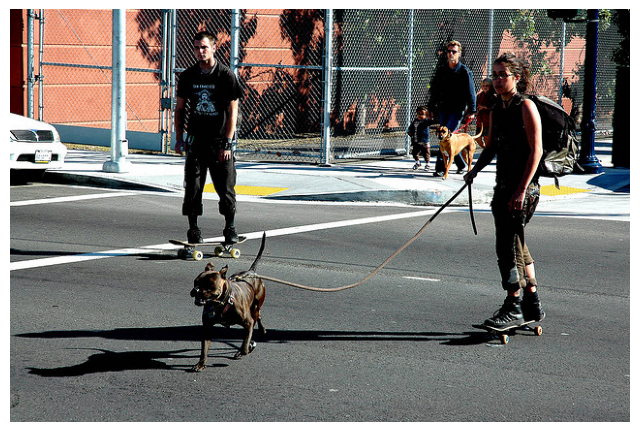

In [15]:
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

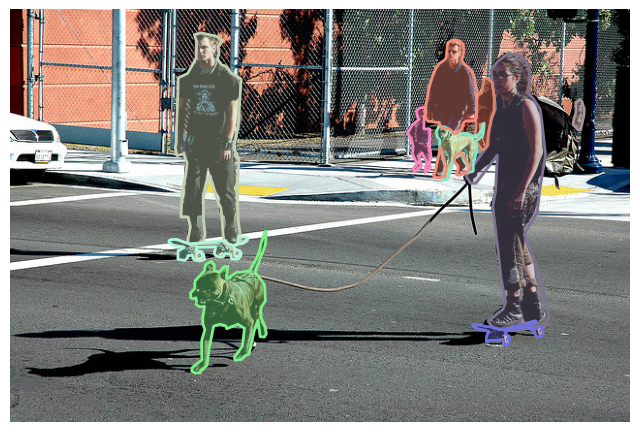

In [16]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco["train2017"].getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco["train2017"].loadAnns(annIds)
coco["train2017"].showAnns(anns)

#### Caption Viewing

The code below demostrates loading the captions of the dataset based on image id of the COCO annotations 

In [17]:
dataDir='./dataset'
dataTypes=['train2017','val2017']

In [18]:
def generate_coco_ds_caption_files(datadir,datatypes):
    coco = dict()
    for dataType in dataTypes:
        annFile='{}/annotations/captions_{}.json'.format(dataDir,dataType)
        coco[dataType]=COCO(annFile)
    return coco

In [19]:
coco_caps = generate_coco_ds_caption_files(datadir=dataDir,datatypes=dataTypes)

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


[717924, 724539, 725124, 726279, 730176]
A person walking a dog on a leash down a street.
THIS IS A GIRL ON A SKATEBOARD WALKING HER PIT BULL
a person that is walking a dog down the street
A person riding on their skateboard while walking their dog.
Her pit bull takes the lead when she is on her skateboard.


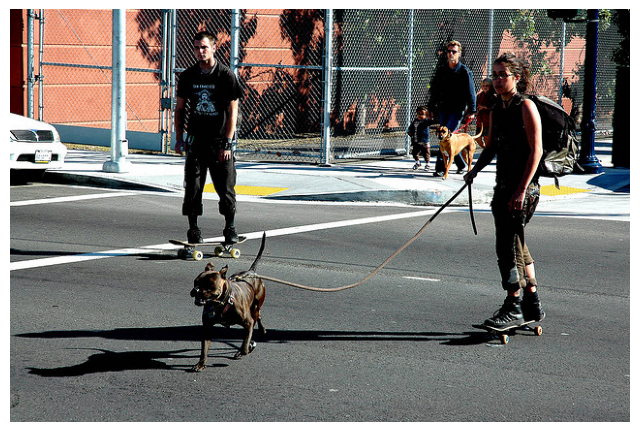

In [20]:
# load and display caption annotations
annIds = coco_caps["train2017"].getAnnIds(imgIds=img['id'])
print(annIds)
anns = coco_caps["train2017"].loadAnns(annIds)
coco_caps["train2017"].showAnns(anns)
plt.imshow(I); plt.axis('off'); plt.show()

#### Review

Now we have a solid understanding of what to do in order to load the COCO dataset. 

### Model Installation

In [43]:
inception_model_pretrained = InceptionV3(weights='imagenet',classifier_activation=None)
inception_model_pretrained.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_282 (Conv2D) │ (None, 149, 149,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_282[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_282      │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_283 (Conv2D) │ (None, 147, 147,  │      9,216 │ activation_282[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_283[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_283      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_284 (Conv2D) │ (None, 147, 147,  │     18,432 │ activation_283[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_284[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_284      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 73, 73,    │          0 │ activation_284[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_285 (Conv2D) │ (None, 73, 73,    │      5,120 │ max_pooling2d_12… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_285[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_285      │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_286 (Conv2D) │ (None, 71, 71,    │    138,240 │ activation_285[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_286[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_286      │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 23,851,784 (90.99 MB)

 Trainable params: 23,817,352 (90.86 MB)

 Non-trainable params: 34,432 (134.50 KB)

### Input Setup

Before getting to the next part of the model build, we will demonstrate the build up of both the image and the caption set at once. 

In [41]:
coco # Annotations Object of Train 2017, Validation 2017 Datasets

{'train2017': <pycocotools.coco.COCO at 0x12471e110>,
 'val2017': <pycocotools.coco.COCO at 0x30cd10710>}

In [42]:
coco_caps # Captions Object of Train 2017, Validation 2017 Datasets

{'train2017': <pycocotools.coco.COCO at 0x314d970d0>,
 'val2017': <pycocotools.coco.COCO at 0x3b4ef67d0>}

In [46]:
img_ids={}
img_ids["train2017"] = coco["train2017"].getImgIds()
img_ids["val2017"] = coco["val2017"].getImgIds()
len(img_ids["train2017"]),len(img_ids["val2017"])

(118287, 5000)

We have approximately 118,000 training images and just 5000 for validation. 

We are now buliding a simple method to demostrate image and caption side-by-side

In [63]:
def generate_images_and_captions(setType,img_ids=[],printSingleImage=False):
    try:
        if(printSingleImage):
            try:
                print("Printing Random Image")
                image_ids=coco[setType].getImgIds()
                unique_img_id = image_ids[np.random.randint(0,len(image_ids)-1)]
                unique_img = coco[setType].loadImgs(unique_img_id)
                unique_ann_id = coco_caps[setType].getAnnIds(imgIds=[unique_img_id])
                unique_ann = coco_caps[setType].loadAnns(unique_ann_id)
                print(unique_img[0])
                unique_img_object = io.imread(unique_img[0]['coco_url'])
                plt.imshow(unique_img_object)
                plt.axis('off')
                plt.show()
                print("COCO URL: ",unique_img[0]['coco_url'])
                print("----Annotations----")
                coco_caps[setType].showAnns(unique_ann)
                
            except:
                print("There has been an unexpected error.")
                return None
        if(img_ids==[]):
            collection={}
            image_ids=coco[setType].getImgIds()
            images = coco[setType].loadImgs(image_ids)
            annIds = coco_caps[setType].getAnnIds()
            anns = coco_caps[setType].loadAnns(annIds)
            collection["images"] = images
            collection["anns"] = anns
            return collection
        else:
            collection={}
            image_ids=coco[setType].getImgIds(img_ids=img_ids)
            images = coco[setType].loadImgs(image_ids)
            annIds = coco_caps[setType].getAnnIds(img_ids=img_ids)
            anns = coco_caps[setType].loadAnns(annIds)
            collection["images"] = images
            collection["anns"] = anns
            return collection
        
    except:
        print("There has been an unexpected error.")
        return None

Now generating input/output set with a random image+annotation print

Printing Random Image
{'license': 3, 'file_name': '000000279543.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000279543.jpg', 'height': 425, 'width': 640, 'date_captured': '2013-11-16 02:54:19', 'flickr_url': 'http://farm7.staticflickr.com/6185/6023617047_3130d04d8d_z.jpg', 'id': 279543}


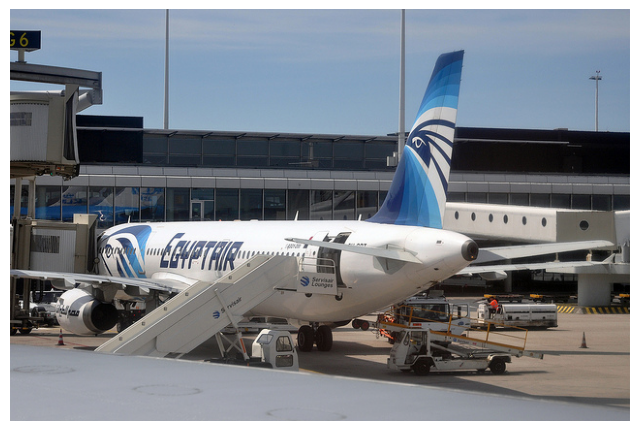

COCO URL:  http://images.cocodataset.org/train2017/000000279543.jpg
----Annotations----
Boarding ladders are attached to the side of a large airliner.
A large jetliner sitting on top of an airport runway.
An airplane parked at the airport with trucks parked around it. 
An Egyptian airplane sits on the tarmac at an airport.
A blue and white commercial airliner on an airport runway.


In [64]:
data={}
data["train2017"] = generate_images_and_captions("train2017",printSingleImage=True)
data["val2017"] = generate_images_and_captions("val2017",printSingleImage=False)

### Generating Feature Vectors

After setting up data input/output for our main task, we focus on our next step, `Feature Generation` with the pre-trained `InceptionV3` model, with the last layer removed to augment the model for our task of caption generation.

In [66]:
inception_model_pretrained = Model(inception_model_pretrained.input, inception_model_pretrained.layers[-2].output)
inception_model_pretrained.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_282 (Conv2D) │ (None, 149, 149,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_282[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_282      │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_283 (Conv2D) │ (None, 147, 147,  │      9,216 │ activation_282[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_283[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_283      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_284 (Conv2D) │ (None, 147, 147,  │     18,432 │ activation_283[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_284[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_284      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 73, 73,    │          0 │ activation_284[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_285 (Conv2D) │ (None, 73, 73,    │      5,120 │ max_pooling2d_12… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_285[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_285      │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_286 (Conv2D) │ (None, 71, 71,    │    138,240 │ activation_285[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_286[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_286      │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [82]:
# Mini-model method to break long-variable loops

def break_loop(index,count=5):
    if(count==None):
        return False
    if index>=count:
        return True
    else:
        return False

In [78]:
def extract_features(img, model):
    img = np.resize(img,(299, 299))
    if img.shape == (299, 299, 3):
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        feature = model.predict(img, verbose=0)
        return feature.reshape(-1)
    return None

In [195]:
features = {
    "train2017":{},
    "val2017":{}
}

index=0

for img_file in tqdm(data["train2017"]["images"]):
    img_obj = io.imread(img_file['coco_url'])
    img_id  = img_file["id"]
    features["train2017"][img_id] = extract_features(img_obj, inception_model_pretrained)
    index+=1
    if break_loop(index,count=100):
        break

index=0

for img_file in tqdm(data["val2017"]["images"]):
    img_obj = io.imread(img_file['coco_url'])
    img_id  = img_file["id"]
    features["val2017"][img_id] = extract_features(img_obj, inception_model_pretrained)
    index+=1
    if break_loop(index,count=100):
        break


  2%|▏         | 99/5000 [00:25<21:21,  3.82it/s]


### Caption Preprocessing

Since we have paired up images and captions, we can preprocess the captions to embedding vectors to make the comparision with the generated vector output.

In [149]:
def preprocess_caption(caption):
    caption = caption.lower()
    caption = re.sub(r'[^a-z\s]', '', caption)
    caption = ' '.join(caption.split())
    caption = "startseq " + caption + " endseq"
    return caption


After building the method, we preprocess our train dataset captions and create a vocab list from them.

In [162]:
# Prepare tokenizer
all_captions={}
all_captions["train2017"] = [preprocess_caption(item['caption']) for item in data["train2017"]["anns"]]
print(len(all_captions["train2017"]))
set_captions_list = list(set((" ".join(all_captions["train2017"])).split(" ")))
vocab = ["UNK"]+ ["PAD"]+ list(set_captions_list)
vocab

591753


['UNK',
 'PAD',
 'restauraint',
 'vignette',
 'armband',
 'dumm',
 'cruets',
 'dramaticly',
 'magicians',
 'delicacies',
 'thriving',
 'jiffy',
 'antic',
 'rent',
 'walking',
 'damn',
 'ktichen',
 'wornout',
 'forhead',
 'costumed',
 'joined',
 'silouhetted',
 'strapping',
 'bowlders',
 'boast',
 'deface',
 'crumpled',
 'surfboars',
 'hardcase',
 'nbc',
 'rocking',
 'lemonbroccolichicken',
 'loud',
 'structures',
 'lanai',
 'salon',
 'reigns',
 'racqet',
 'recommending',
 'ranches',
 'troopers',
 'blackblue',
 'threeprong',
 'taxidermied',
 'meatbeans',
 'swimwear',
 'madeup',
 'seentwo',
 'papermache',
 'businesss',
 'winning',
 'sterlingeu',
 'accompaniment',
 'module',
 'aeg',
 'enquiries',
 'smoke',
 'hbf',
 'parasailers',
 'flashlights',
 'camouflaged',
 'passsanger',
 'rowboats',
 'exhibited',
 'persong',
 'gasmask',
 'dreamily',
 'railway',
 'kisses',
 'jogs',
 'angora',
 'parkland',
 'wildy',
 'splashy',
 'harbor',
 'curtis',
 'flecked',
 'pan',
 'lightstrain',
 'toss',
 'brain

### Tokenization

Now we build a `WordPieceTokenizer` from the generated vocabulary list.

In [176]:
wp_tokenizer = WordPieceTokenizer(
    vocabulary=vocab,
    lowercase=True,
    oov_token='UNK',
    dtype="int32",
)

In [177]:
vocab_size = wp_tokenizer.vocabulary_size()
max_length = max(len(c.split()) for c in all_captions["train2017"])
print(vocab_size)
print(max_length)

28563
51


In [178]:
wp_tokenizer.get_vocabulary()

['UNK',
 'PAD',
 'restauraint',
 'vignette',
 'armband',
 'dumm',
 'cruets',
 'dramaticly',
 'magicians',
 'delicacies',
 'thriving',
 'jiffy',
 'antic',
 'rent',
 'walking',
 'damn',
 'ktichen',
 'wornout',
 'forhead',
 'costumed',
 'joined',
 'silouhetted',
 'strapping',
 'bowlders',
 'boast',
 'deface',
 'crumpled',
 'surfboars',
 'hardcase',
 'nbc',
 'rocking',
 'lemonbroccolichicken',
 'loud',
 'structures',
 'lanai',
 'salon',
 'reigns',
 'racqet',
 'recommending',
 'ranches',
 'troopers',
 'blackblue',
 'threeprong',
 'taxidermied',
 'meatbeans',
 'swimwear',
 'madeup',
 'seentwo',
 'papermache',
 'businesss',
 'winning',
 'sterlingeu',
 'accompaniment',
 'module',
 'aeg',
 'enquiries',
 'smoke',
 'hbf',
 'parasailers',
 'flashlights',
 'camouflaged',
 'passsanger',
 'rowboats',
 'exhibited',
 'persong',
 'gasmask',
 'dreamily',
 'railway',
 'kisses',
 'jogs',
 'angora',
 'parkland',
 'wildy',
 'splashy',
 'harbor',
 'curtis',
 'flecked',
 'pan',
 'lightstrain',
 'toss',
 'brain

In [179]:
wp_tokenizer.tokenize(all_captions["train2017"][0])

<tf.Tensor: shape=(12,), dtype=int32, numpy=
array([ 9705,  8653, 19163,  5634, 16024,  8653, 21834,  1531, 21602,
       19187, 20461, 17287], dtype=int32)>

In [180]:
print(wp_tokenizer.token_to_id("startseq"))
print(wp_tokenizer.token_to_id("endseq"))
print(wp_tokenizer.token_to_id("UNK"))
print(wp_tokenizer.token_to_id("PAD"))


9705
17287
0
1


Saving this WP Tokenizer.

In [181]:
with open('wp_tokenizer.pkl', 'wb') as f:
    pickle.dump(wp_tokenizer, f)

### Sequence Padding

Now after saving the WP Tokenizer, we build a method to pad our sequences of words.

First of all, we load back the Word Piece Tokenizer

In [186]:
with open('wp_tokenizer.pkl', 'rb') as file:
    wp_tokenizer = pickle.load(file)
wp_tokenizer # build=True comes when it is used inside a model.

<WordPieceTokenizer name=word_piece_tokenizer_23, built=False>

> Mini model implemnetation

In [188]:
caption_sequences = [wp_tokenizer.tokenize(seq) for seq in all_captions["train2017"][:100]]

In [197]:
padded_caption_sequences = pad_sequences(
    caption_sequences,
    maxlen=max_length,
    padding='post',
    value=1
)

In [198]:
wp_tokenizer.detokenize(padded_caption_sequences[0])

'startseq a bicycle replica with a clock as the front wheel endseq PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD'

### Model Implementation

Now we define our models with this method below. These two models will be our LSTM and GRU models.

In [199]:
vocab_size = vocab_size
max_length = max_length

In [200]:
# Define LSTM and GRU models
def define_model(vocab_size, max_length, embedding_dim=256, rnn_type="LSTM"):
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(embedding_dim, activation='relu')(fe1)
    
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    if rnn_type == "LSTM":
        se3 = LSTM(256)(se2)
    else:
        se3 = GRU(256)(se2)
    
    decoder1 = Add()([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

# Create models for both LSTM and GRU
lstm_model = define_model(vocab_size, max_length, rnn_type="LSTM")
gru_model = define_model(vocab_size, max_length, rnn_type="GRU")


Here below is the summary of our models

In [201]:
lstm_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 51, 256)   │  7,312,128 │ input_layer_13[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 2048)      │          0 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 51, 256)   │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 51)        │          0 │ input_layer_13[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    524,544 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 256)       │    525,312 │ dropout_9[0][0],  │
│                     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 256)       │          0 │ dense_12[0][0],   │
│                     │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │     65,792 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 28563)     │  7,340,691 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,768,467 (60.15 MB)

 Trainable params: 15,768,467 (60.15 MB)

 Non-trainable params: 0 (0.00 B)

In [202]:
gru_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 51, 256)   │  7,312,128 │ input_layer_15[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 2048)      │          0 │ input_layer_14[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 51, 256)   │          0 │ embedding_5[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 51)        │          0 │ input_layer_15[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │    524,544 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 256)       │    394,752 │ dropout_11[0][0], │
│                     │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 256)       │          0 │ dense_15[0][0],   │
│                     │                   │            │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 256)       │     65,792 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 28563)     │  7,340,691 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,637,907 (59.65 MB)

 Trainable params: 15,637,907 (59.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def generate_padded_seq(seq, wp_tokenizer):
    seq=wp_tokenizer.tokenize(seq)
    padded_seq = pad_sequences(
        [seq],
        maxlen=max_length,
        padding='post',
        value=1
    )
    return padded_seq

In [ ]:
for img_id, cap_list in tqdm(captions.items()):
    if img_id in features["train2017"]:
        img_features = features["train2017"][img_id]
        padded_seq = 
        X1, X2, y = create_sequences(tokenizer, max_length, cap_list, img_features)
        X1train.extend(X1)
        X2train.extend(X2)
        ytrain.extend(y)
    else:
        print(f"Image ID {img_id} not found in features.")


In [ ]:
# Train the LSTM model
X1train, X2train, ytrain = [], [], []
for img_id, cap_list in tqdm(captions.items()):
    img_features = features[img_id]
    X1, X2, y = create_sequences(tokenizer, max_length, cap_list, img_features)
    X1train.extend(X1)
    X2train.extend(X2)
    ytrain.extend(y)

X1train, X2train, ytrain = np.array(X1train), np.array(X2train), np.array(ytrain)

lstm_model.fit([X1train, X2train], ytrain, epochs=20, batch_size=64)
gru_model.fit([X1train, X2train], ytrain, epochs=20, batch_size=64)


In [ ]:
def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word[yhat]
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

# Test on sample images
for img_id in list(captions.keys())[:5]:
    caption = generate_caption(lstm_model, tokenizer, features[img_id].reshape(1, 2048), max_length)
    print("LSTM Caption:", caption)
    caption = generate_caption(gru_model, tokenizer, features[img_id].reshape(1, 2048), max_length)
    print("GRU Caption:", caption)


In [ ]:
# Calculate BLEU and semantic distance
def evaluate_model(model, tokenizer, photos, captions, max_length):
    actual, predicted = [], []
    for key, desc_list in captions.items():
        y_pred = generate_caption(model, tokenizer, photos[key], max_length)
        references = [d.split() for d in desc_list]
        y_pred = y_pred.split()
        bleu = sentence_bleu(references, y_pred)
        actual.append(references)
        predicted.append(y_pred)
        print(f'BLEU: {bleu:.3f}')


# Observations

# Conclusion

# Scope

- Future potential for compatibility with Large Language Models. Document based generation with Formated texts and Images embedded in a formatted fashion.
- Potential Model Improvements and Dataset Improvements.
- Scope for Image Generation with larger, diverse datasets. 